# Load Libraries

In [61]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import copy
import pickle
import os

workingFolder = '/Users/kaigu/Documents/Universität/Doktorand/Projekte/KI-Regio/'

# Feature Engineering

The following pipeline combines temporal, weather, and domain-specific features to capture patterns in pedestrian movement:

### Temporal Features

- Base time features: Year, month, day, day of week, hour of week
- Cyclical encoding: For hour, day of week, and month
- Time blocks: Weekend indicators, rush hour, shopping hours, work hours

### Statistical & Lag Features

- Historical averages
- Lag features

### Weather Features

- Weather encoding: Numerical representation of weather conditions
- Temperature transformations: Squared values, normalized values
- Temperature bands: Cold (<5°C), mild (5-15°C), warm (15-25°C), hot (>25°C)

### Domain-Specific Features

- Local events
- University patterns: Semester periods, exam periods
- Tourism indicators
- Holiday features: Public holidays, school holidays, bridge days between holidays and weekends

### Others

In [62]:
def create_lag_features(df, target_cols, lag_hours=[1, 2, 3, 24, 168], rolling_windows=[3, 6, 12, 24], is_train=True):
    df = df.copy()
    df = df.sort_values(['streetname', 'datetime'])
    
    if is_train:
        avg_values = {}
        for street in df['streetname'].unique():
            street_mask = df['streetname'] == street
            street_data = df[street_mask]
            
            avg_values[street] = {}
            for target in target_cols:
                if target in df.columns:
                    avg_values[street][f'{target}_dow_avg'] = street_data.groupby('day_of_week')[target].mean().to_dict()
                    avg_values[street][f'{target}_hour_avg'] = street_data.groupby('hour')[target].mean().to_dict()
                    avg_values[street][f'{target}_hour_of_week_avg'] = street_data.groupby('hour_of_week')[target].mean().to_dict()
                    avg_values[street][f'{target}_recent'] = street_data[target].iloc[-lag_hours[0]:].mean()
        return df, avg_values
    else:
        for street in df['streetname'].unique():
            street_mask = df['streetname'] == street
            for window in rolling_windows:
                df.loc[street_mask, f'temp_rolling_mean_{window}h'] = df.loc[street_mask, 'temperature'].rolling(window=window, min_periods=1).mean()
            df.loc[street_mask, 'temp_hour_avg'] = df.loc[street_mask].groupby('hour')['temperature'].transform('mean')
            df.loc[street_mask, 'temp_dow_avg'] = df.loc[street_mask].groupby('day_of_week')['temperature'].transform('mean')
        return df, None


def create_base_time_features(df):
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')
    df['year'], df['month'], df['day'] = df['datetime'].dt.year, df['datetime'].dt.month, df['datetime'].dt.day
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['hour_of_week'] = df['day_of_week'] * 24 + df['hour']
    
    for unit, period in [('hour', 24), ('day_of_week', 7), ('month', 12)]:
        df[f'{unit}_sin'] = np.sin(2 * np.pi * df[unit]/period)
        df[f'{unit}_cos'] = np.cos(2 * np.pi * df[unit]/period)
    
    return df

def create_time_block_features(df):
    time_blocks = {
        'is_weekend': df['day_of_week'].isin([5, 6]),
        'is_peak_day': df['day_of_week'].isin([2,3,4]),
        'is_morning_rush': (df['hour'].between(7, 9)),
        'is_evening_rush': (df['hour'].between(16, 18)),
        'is_rush_hour': (df['hour'].between(7, 9) | df['hour'].between(16, 18)),
        'is_shopping_hours': (df['hour'].between(10, 19)),
        'is_working_hours': (df['hour'].between(9, 17)),
        'is_lunch_time': (df['hour'].between(11, 14)),
        'is_night': ((df['hour'] >= 22) | (df['hour'] <= 5)),
        'is_tourist_hours': (df['hour'].between(10, 18))
    }
    
    for name, condition in time_blocks.items():
        df[name] = condition.astype(int)
    return df

def create_weather_features(df):
    df['weather_encoded'] = df['weather_condition'].map({
        'partly-cloudy-day': 1, 'partly-cloudy-night': 2, 'cloudy': 3,
        'clear-day': 4, 'clear-night': 5, 'rain': 6
    })
    
    df = pd.concat([df, pd.get_dummies(df['weather_condition'], prefix='weather')], axis=1)
    df['temp_squared'], df['temp_norm'] = df['temperature'] ** 2, (df['temperature'] - 15) / 10
    
    df['temp_band'] = pd.cut(df['temperature'], bins=[-np.inf, 5, 15, 25, np.inf], labels=['cold', 'mild', 'warm', 'hot'])
    df = pd.concat([df, pd.get_dummies(df['temp_band'], prefix='temp')], axis=1)
    return df

def add_wurzburg_events(df):

    eventsDf = pd.read_csv(f'{workingFolder}data_general/events_daily.csv')
    lecturesDf = pd.read_csv(f'{workingFolder}data_general/lectures_daily.csv')

    # Split up date in eventsDf into date and hour
    eventsDf['hour'] = pd.to_datetime(eventsDf['date']).dt.hour.astype('int64')
    eventsDf['date'] = pd.to_datetime(eventsDf['date']).dt.date.astype('str')

    df = df.merge(eventsDf, on = ['date', 'hour'], how='left')

    df = df.merge(lecturesDf, on='date', how='left')
    
    df['is_exam_period'] = (df['month'].isin([1,2,7,8])).astype(int)
    
    return df

def add_enhanced_holiday_features(df):
    
    publicHolidaysDf =  pd.read_csv(f'{workingFolder}data_general/bavarian_public_holidays_daily.csv')
    schoolHolidaysDf =  pd.read_csv(f'{workingFolder}data_general/bavarian_school_holidays_daily.csv')

    df = df.merge(publicHolidaysDf, on='date', how='left')

    df['is_bridge_day'] = (
        ((df['public_holiday'].shift(1) == 1) & (df['is_weekend'] == 1)) |
        ((df['public_holiday'] == 1) & (df['is_weekend'].shift(-1) == 1))
    ).astype(int)

    df['is_public_holiday_nationwide'] = (df['public_holiday'] & df['nationwide'])

    df = df.merge(schoolHolidaysDf, on='date', how='left')

    # Rename 'public_holiday' to 'is_public_holiday' and 'school_holiday' to 'is_school_holiday'
    df.rename(columns={'public_holiday': 'is_public_holiday', 'school_holiday': 'is_school_holiday'}, inplace=True)
    
    return df


def add_street_features(df):
    df['street_encoded'] = LabelEncoder().fit_transform(df['streetname'])
    df['is_kaiserstrasse_shopping'] = ((df['streetname'] == 'Kaiserstrasse') & (df['is_shopping_hours'] == 1)).astype(int)
    df['is_spiegelstrasse_rush'] = ((df['streetname'] == 'Spiegelstrasse') & (df['is_rush_hour'] == 1)).astype(int)
    return df


def create_interaction_features(df):
    interactions = {
        'temp_hour': df['temperature'] * df['hour'],
        'weekend_hour': df['is_weekend'] * df['hour'],
        'temp_shopping_hours': df['temperature'] * df['is_shopping_hours'],
        'rain_rush_hour': (df['weather_condition'] == 'rain') & df['is_rush_hour'],
        'rain_weekend': (df['weather_condition'] == 'rain') & df['is_weekend']
    }
    
    for name, interaction in interactions.items():
        df[name] = interaction.astype(int)
    return df

def create_seasonal_features(df):
    df['covid_lockdown'] = ((df['date'] >= '2020-03') & (df['date'] <= '2020-06')).astype(int)
    df['covid_lockdown_lift'] = ((df['date'] >= '2020-06') & (df['date'] <= '2021-05')).astype(int)
    df['covid_lull'] = ((df['date'] >= '2021-06') & (df['date'] <= '2022-04')).astype(int)
    df['post_covid_recovery'] = ((df['date'] >= '2022-05') & (df['date'] <= '2022-12')).astype(int)

    df['season'] = pd.cut(df['month'], bins=[0,3,6,9,12], labels=['winter','spring','summer','fall'])
    df = pd.concat([df, pd.get_dummies(df['season'], prefix='season')], axis=1)
    
    df['is_tourist_season'] = df['month'].isin([5,6,7,8,9,10]).astype(int)
    df['is_weekend_tourist_season'] = (df['is_weekend'] & df['is_tourist_season']).astype(int)
    return df


def get_feature_columns(df):
    exclude_cols = ['id', 'datetime', 'date', 'streetname', 'city',
                   'n_pedestrians', 'n_pedestrians_towards', 'n_pedestrians_away',
                   'incidents', 'collection_type', 'season', 'temp_band', 'weather_condition']
    
    return [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in exclude_cols]


def create_all_features(df, is_train=True, train_avg_values=None):
    original_index = df.index
    df = create_base_time_features(df)
    df = create_time_block_features(df)
    df = create_weather_features(df)
    df = create_seasonal_features(df)
    df = add_wurzburg_events(df)
    df = add_enhanced_holiday_features(df)
    df = create_interaction_features(df)
    df = add_street_features(df)
    
    target_cols = ['n_pedestrians', 'n_pedestrians_towards', 'n_pedestrians_away']
    
    if is_train:
        df, avg_values = create_lag_features(df, target_cols=target_cols, is_train=True)
    else:
        df, _ = create_lag_features(df, target_cols=target_cols, is_train=False)
        
        if train_avg_values:
            for street in df['streetname'].unique():
                street_mask = df['streetname'] == street
                if street in train_avg_values:
                    for target in target_cols:
                        df.loc[street_mask, f'{target}_dow_avg'] = df.loc[street_mask, 'day_of_week'].map(
                            train_avg_values[street][f'{target}_dow_avg'])
                        df.loc[street_mask, f'{target}_hour_avg'] = df.loc[street_mask, 'hour'].map(
                            train_avg_values[street][f'{target}_hour_avg'])
                        df.loc[street_mask, f'{target}_hour_of_week_avg'] = df.loc[street_mask, 'hour_of_week'].map(
                            train_avg_values[street][f'{target}_hour_of_week_avg'])
                        
                        recent_value = train_avg_values[street][f'{target}_recent']
                        for lag in [1, 2, 3, 24, 168]:
                            df.loc[street_mask, f'{target}_lag_{lag}h'] = recent_value
    
    le = LabelEncoder()
    for col in df.select_dtypes(include=['object']).columns:
        if col not in ['id', 'streetname', 'date']:
            df[f'{col}_encoded'] = le.fit_transform(df[col])
    
    df.index = original_index
    
    return (df, avg_values) if is_train else df

`test_df_submission` is being used to generate the submission file for the kaggle competition. It contains both the public and private test data. 
`test_df`, on the other hand, is being used as the internal test data for this script for plotting purposes. We need this differentiation to be able to train and evaluate on the public leaderboard data and still smoothly generate our submission file.

In [63]:
test_df = pd.read_csv(f'{workingFolder}kaggle_v2/data_foot_traffic/test.csv')
test_df.date.max()

'2025-02-16'

In [64]:
train_df = pd.read_csv(f'{workingFolder}kaggle_v2/data_foot_traffic/train.csv')
test_df = pd.read_csv(f'{workingFolder}kaggle_v2/data_foot_traffic/test.csv')
solution_df = pd.read_csv(f'{workingFolder}kaggle_v2/data_foot_traffic/solution.csv')

X_publicTest = test_df[test_df['id'].isin(solution_df[solution_df.Usage == 'Public'].id)]
X_publicTest = X_publicTest.merge(solution_df[solution_df.Usage == 'Public'], on='id', how='left')
X_publicTest.drop(columns=['Usage'], inplace=True)

test_df_submission = copy.deepcopy(test_df)

val_test_actuals = pd.read_csv(f'{workingFolder}kaggle_v2/data_foot_traffic/val_test_actuals.csv')

#---

# # OPTIONAL: Use public kaggle data as training data
# train_df = pd.concat([train_df, X_publicTest], ignore_index=True).reset_index(drop=True)

# # Remove all ids that are part of X_public from test_df
# test_df = test_df[~test_df['id'].isin(X_publicTest['id'])].reset_index(drop=True)

#---

print("Creating training features...")
train_df, train_avg_values = create_all_features(train_df, is_train=True)

print("Creating test features...")
test_df = create_all_features(test_df, is_train=False, train_avg_values=train_avg_values)

print("Creating test submission features...")
test_df_submission = create_all_features(test_df_submission, is_train=False, train_avg_values=train_avg_values)

val_test_actuals = create_base_time_features(val_test_actuals)

#---

#---

# OPTIONAL: Removal of datapoints 

# # Remove all data that is after 2020-03 and before 2022-06
# train_df = train_df[(train_df['date'] < '2020-03') | (train_df['date'] > '2022-06')]

# # Remove all features that contain the word 'covid'
# train_df = train_df.loc[:, ~train_df.columns.str.contains('covid')]
# test_df = test_df.loc[:, ~test_df.columns.str.contains('covid')]

# Remove all observations with incidents_encoded != 2 und collection_type_encoded != 0
train_df = train_df[(train_df['incidents_encoded'] == 2) & (train_df['collection_type_encoded'] == 0)].reset_index(drop=True)
train_df = train_df.drop(columns=['incidents_encoded', 'collection_type_encoded'])

#---

feature_cols = get_feature_columns(train_df)
print(f"Using {len(feature_cols)} features: {feature_cols}")

for col in feature_cols:
    if train_df[col].isnull().any():
        print(f"Warning: Missing values in column {col}")
        train_df[col] = train_df[col].fillna(train_df[col].mean())
        test_df[col] = test_df[col].fillna(train_df[col].mean())

train_df['date'] = pd.to_datetime(train_df['date'])
last_date = train_df['date'].max()
cutoff_date = last_date - pd.DateOffset(months=16)
val_start_date = last_date - pd.DateOffset(months=0, weeks=1)

train_mask = (train_df['date'] >= cutoff_date) & (train_df['date'] < val_start_date)
X_train = train_df[train_mask]
X_val = train_df[train_df['date'] >= val_start_date]


Creating training features...
Creating test features...
Creating test submission features...
Using 50 features: ['hour', 'temperature', 'hour_of_week', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_peak_day', 'is_morning_rush', 'is_evening_rush', 'is_rush_hour', 'is_shopping_hours', 'is_working_hours', 'is_lunch_time', 'is_night', 'is_tourist_hours', 'weather_encoded', 'temp_squared', 'temp_norm', 'covid_lockdown', 'covid_lockdown_lift', 'covid_lull', 'post_covid_recovery', 'is_tourist_season', 'is_weekend_tourist_season', 'event', 'concert', 'lecture_period_jmu', 'lecture_period_thws', 'lecture_period_both', 'is_exam_period', 'is_public_holiday', 'nationwide', 'is_bridge_day', 'is_public_holiday_nationwide', 'is_school_holiday', 'temp_hour', 'weekend_hour', 'temp_shopping_hours', 'rain_rush_hour', 'rain_weekend', 'street_encoded', 'is_kaiserstrasse_shopping', 'is_spiegelstrasse_rush', 'city_encoded', 'weekday_encoded', 'weath

# Model training and evaluation

### 3 models:
- Random Forest: 200 trees, max depth 20
- LightGBM: 200 estimators, learning rate 0.02, max depth 8
- XGBoost: 200 estimators, learning rate 0.05, max depth 8

### Model Selection

- Each target variable has its own best-performing model selected based on validation MSE
- Street-level metrics calculated to understand model performance across different locations
- Feature importance analysis to identify key predictors for each target

### Visualization

- Time series plots comparing actual vs. predicted values for each street
- Visual comparison of model predictions during validation and test periods
- Vertical indicators to mark the beginning of the test period

## Moddeling Functions

In [65]:
def get_cv_splits(df, n_splits=5, len_split=168):

    df.reset_index(drop=True, inplace=True)

    cv_splits = []

    for i in range(n_splits):

        ids_train = []
        ids_val = []

        for street in df.streetname.unique():
            street_mask = df.streetname == street
            df_street = df[street_mask]

            len_street = df_street.shape[0]

            split_point = len_street - len_split * (i + 1)
            end_point = len_street - len_split * i
            
            ids_train.append(df_street.iloc[:split_point, :].index)
            ids_val.append(df_street.iloc[split_point:end_point, :].index)
            
        ids_train = np.concatenate(ids_train, axis=0)
        ids_val = np.concatenate(ids_val, axis=0)

        cv_splits.append((ids_train, ids_val))
    
    return cv_splits


def tune_model_random(model, param_dist, X, y, cv_splits, n_iter=10, n_jobs=16, verbose=1):

    best_model = None
    best_score = float('inf')

    cv = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='neg_mean_squared_error',
        cv=cv_splits,
        refit=True,
        n_jobs=n_jobs,
        verbose=verbose)
    
    cv.fit(X, y)
    
    return cv


def tune_model_bayes(model, param_dist, X, y, cv_splits, n_iter=10, n_points=1, n_jobs=16, verbose=1):

    best_model = None
    best_score = float('inf')

    cv = BayesSearchCV(
        estimator=model,
        search_spaces=param_dist,
        n_iter=n_iter,
        n_points=n_points,
        scoring='neg_mean_squared_error',
        cv=cv_splits,
        n_jobs=n_jobs,
        verbose=verbose,
        random_state=42)
    
    cv.fit(X, y)
    
    return cv


def get_best_model(models_dict, y_true, val_predictions_dict):
    best_mse, best_model = float('inf'), None
    
    for model_name, model in models_dict.items():
        mse = mean_squared_error(y_true, val_predictions_dict[model_name])
        if mse < best_mse:
            best_mse, best_model = mse, model_name
    
    return best_model, best_mse




def create_metrics_table(y_true, predictions_dict, target_col):

    return pd.DataFrame([{
        'Model': model_name.upper(),
        'MSE': f"{(mean_squared_error(y_true, preds[target_col])):.2f}",
        'RMSE': f"{np.sqrt(mean_squared_error(y_true, preds[target_col])):.2f}",
        'MAE': f"{(mean_absolute_error(y_true, preds[target_col])):.2f}",
        'MAPE': f"{(np.mean(np.abs((y_true - preds[target_col]) / y_true)) * 100):.2f}%",
        'R2': f"{r2_score(y_true, preds[target_col]):.4f}"
    } for model_name, preds in predictions_dict.items()])


def create_street_metrics(val_df, predictions_dict, target_col):
    street_mask = val_df['streetname'] == street
    return {street: create_metrics_table(
        val_df[street_mask][target_col],
        {model_name: pd.DataFrame({target_col: preds.loc[street_mask, target_col]}) 
         for model_name, preds in predictions_dict.items()},
        target_col
    ) for street in val_df['streetname'].unique()}


def display_model_comparison(val_df, val_predictions, test_predictions, best_models):
    for target in ['n_pedestrians', 'n_pedestrians_towards', 'n_pedestrians_away']:
        print(f"\n{'='*80}\nResults for {target}\n{'='*80}\n")
        
        print("Overall Metrics:")
        print(create_metrics_table(val_df[target], val_predictions[target], target).to_string(index=False))
        print("\nStreet-wise Metrics:")
        
        for street, metrics in create_street_metrics(val_df, val_predictions[target], target).items():
            print(f"\n{street}:")
            print(metrics.to_string(index=False))
        
        if target in best_models:
            print(f"\nBest Model Selected: {best_models[target].upper()}")
        print('-'*80)


def display_feature_importance(model, feature_cols, model_name, target):
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\nTop 10 Important Features for {model_name.upper()} - {target}:")
    print(importance_df.head(10).to_string(index=False))
    print()

def display_target_metrics(val_df, predictions, target):
    print(f"\n{'='*80}\nResults for {target}\n{'='*80}\n")
    
    print("Overall Metrics:")
    print(create_metrics_table(val_df[target], predictions, target).to_string(index=False))
    print("\nStreet-wise Metrics:")
    
    for street in val_df['streetname'].unique():
        print(f"\n{street}:")
        mask = val_df['streetname'] == street
        street_preds = {model: pd.DataFrame({target: preds.loc[mask, target]}) for model, preds in predictions.items()}
        print(create_metrics_table(val_df[mask][target], street_preds, target).to_string(index=False))


def plot_model_comparison(val_df, predictions_dict, test_df, test_predictions_dict, val_test_actuals, target_col):
    n_streets = len(val_df['streetname'].unique())
    fig, axes = plt.subplots(n_streets, 1, figsize=(20, 8*n_streets))
    if n_streets == 1: axes = [axes]
    colors = {'rf': 'red', 'lgb': 'green', 'xgb': 'purple'}
    
    for ax, street in zip(axes, val_df['streetname'].unique()):
        street_mask = val_df['streetname'] == street
        ax.plot(val_df[street_mask]['datetime'], val_df[street_mask][target_col], label='Actual', color='blue', alpha=0.7)

        val_test_mask = val_test_actuals['streetname'] == street
        ax.plot(val_test_actuals[val_test_mask]['datetime'], val_test_actuals.loc[val_test_mask, target_col], label='Actual (Val, Test)', color='blue', linestyle='--', alpha=0.7)
        
        for model_name in predictions_dict.keys():
            ax.plot(val_df[street_mask]['datetime'], predictions_dict[model_name].loc[street_mask, target_col], 
                    label=f'{model_name.upper()} (Train)', color=colors[model_name], linestyle='--', alpha=0.7)
            
            test_mask = test_df['streetname'] == street
            ax.plot(test_df[test_mask]['datetime'], test_predictions_dict[model_name].loc[test_mask, target_col],
                    label=f'{model_name.upper()} (Val, Test)', color=colors[model_name], linestyle=':', alpha=0.7)

        min_test_date = test_df['datetime'].min()
        ax.axvline(x=min_test_date, color='black', linestyle='-', alpha=0.3)
        ax.text(min_test_date, ax.get_ylim()[1], 'Test Period Start', rotation=90, verticalalignment='top')
        
        if (target_col == 'n_pedestrians'):
            ax.set_title(f"Number of Pedestrians - {street.capitalize()}", fontsize=18)
        elif (target_col == 'n_pedestrians_towards'):
            ax.set_title(f"Number of Pedestrians Towards - {street.capitalize()}", fontsize=18)
        else:
            ax.set_title(f"Number of Pedestrians Away - {street.capitalize()}", fontsize=18)

        ax.set_xlabel('Date', fontsize = 16)
        ax.set_ylabel('Number of Pedestrians', fontsize = 16)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 12)
        ax.grid(True)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, fontsize = 14)
   
    # plt.suptitle(f'Model Comparison for {target_col} - RMSE Scaled: {rmse_scaled:.2f}', fontsize=16)
    
    plt.tight_layout()
    plt.show()


## Modelling Execution

## Model Definition + Hyperparameter Distributions 

The hyperparameters pre-specified here are good baselines to get solid forecasts. If needed, you can conduct a hyperparameter search with the hyperparameters specified further below in the hyperparameter-search-grids.

In [66]:
models = {
    'lgb': lgb.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=8,
        num_leaves = 200,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=0.1,
        n_jobs=1,
        random_state=42,
        verbose = -1,
        # device = 'gpu',
        # gpu_use_dp = False,
        # max_bin = 255,
    ),
    'xgb': xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.02,
        max_depth=8,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=1,
        random_state=42,
        # tree_method='hist',  
        # device='cuda'                
    )
}

#---

# Needed for Randomized Search

param_dists = {
    'lgb': {
        'n_estimators': randint(100, 1000),
        'learning_rate': uniform(0.01, 0.3),
        'max_depth': randint(4, 11),
        'num_leaves': randint(50, 300),     
        'subsample': uniform(0.4, 0.6),
        'colsample_bytree': uniform(0.4, 0.6),             
        'min_child_samples': randint(1, 50),
        'reg_lambda': uniform(0.1, 20),
    },
    'xgb': {
        'n_estimators': randint(100, 1000),
        'learning_rate': uniform(0.01, 0.3),          
        'max_depth': randint(4, 11),
        'subsample': uniform(0.4, 0.6),               
        'colsample_bytree': uniform(0.4, 0.6),    
        'min_child_weight': randint(1, 50),             
        'reg_lambda': uniform(0.1, 20),         
    }
}

#---

# Needed for Bayesian Search

search_spaces = {
    'lgb': {
        'n_estimators': Integer(100, 1000),              
        'learning_rate': Real(0.01, 0.3, prior='uniform'),
        'max_depth': Integer(4, 11),
        'num_leaves': Integer(50, 300),
        'subsample': Real(0.4, 1, prior='uniform'),
        'colsample_bytree': Real(0.4, 1, prior='uniform'),
        'min_child_samples': Integer(1, 50),
        'reg_lambda': Real(0.1, 20, prior='uniform'),
    },
    'xgb': {
        'n_estimators': Integer(100, 1000),
        'learning_rate': Real(0.01, 0.3, prior='uniform'),
        'max_depth': Integer(4, 11),
        'subsample': Real(0.4, 1, prior='uniform'),
        'colsample_bytree': Real(0.4, 1, prior='uniform'),
        'min_child_weight': Integer(1, 50),
        'reg_lambda': Real(0.1, 20, prior='uniform'),        
    }
}

## Run Models

There are various parameters here that specify how the models are being run / trained:
- ``modelsToUse:`` Currently either 'xgb' (XGBoost) or 'lgb' (LightGBM). If you want to add other models, you have to add them in the above ``models``dictionary.
- ``tune_model_bool``: Either ``True`` or ``False``. Specifies whether cross-validation is being conducted to tune the hyperparameters.
- ``n_splits``: Number of cross-validation splits. Only plays a role, if ``tune_model_bool == True``.
- ``n_iter``: Number of hyperparameter combinations tested when conducting a random hyperparameter search. Only plays a role, if ``tune_model_bool == True``.
- ``n_points_bayesSearch``:  Number of hyperparameter combinations tested when conducting a bayesian hyperparameter search. Only plays a role, if ``tune_model_bool == True``.
- ``n_jobs``: Number of hyperparameter test runs conducted in parallel. Only plays a role, if ``tune_model_bool == True``.
- ``verbose``: Determines how much information is being printed during cross-validation. Only plays a role, if ``tune_model_bool == True``.
    - ``verbose=0`` (default): **No output** is printed—completely silent.
    - ``verbose=1``: **Minimal output**, often includes a short message for each parameter set evaluated.
    - ``verbose=2``: **More detailed output**, including score results and timings for each iteration. 
    - ``verbose=3+``: **Very detailed output**
- ``retrain_on_val``: We specify a validation set that is used to determine whether which of the considered models (specified in ``modelsToUse``) is being used to create the final forecasts on the test set. If ``retrain_on_val == True``, the final model is retrained on the combination of the training and validation data before generating the forecasts for the test set.
- ``deseaonlize``: If ``True``, the time series data is deseasonalized before training the model. From my experience, this does not improve the forecasting results, but it makes it easier to assess the influence of the different features on the forecasts, because in the model without deseasonlization, features like the hour of the day naturally dominate the feature importants by huge margin.
- ``output_path``: Where to save the csv-file containing the forecasts.


Processing n_pedestrians...
Training XGB...
Training Complete

Generating comparison plot for n_pedestrians...


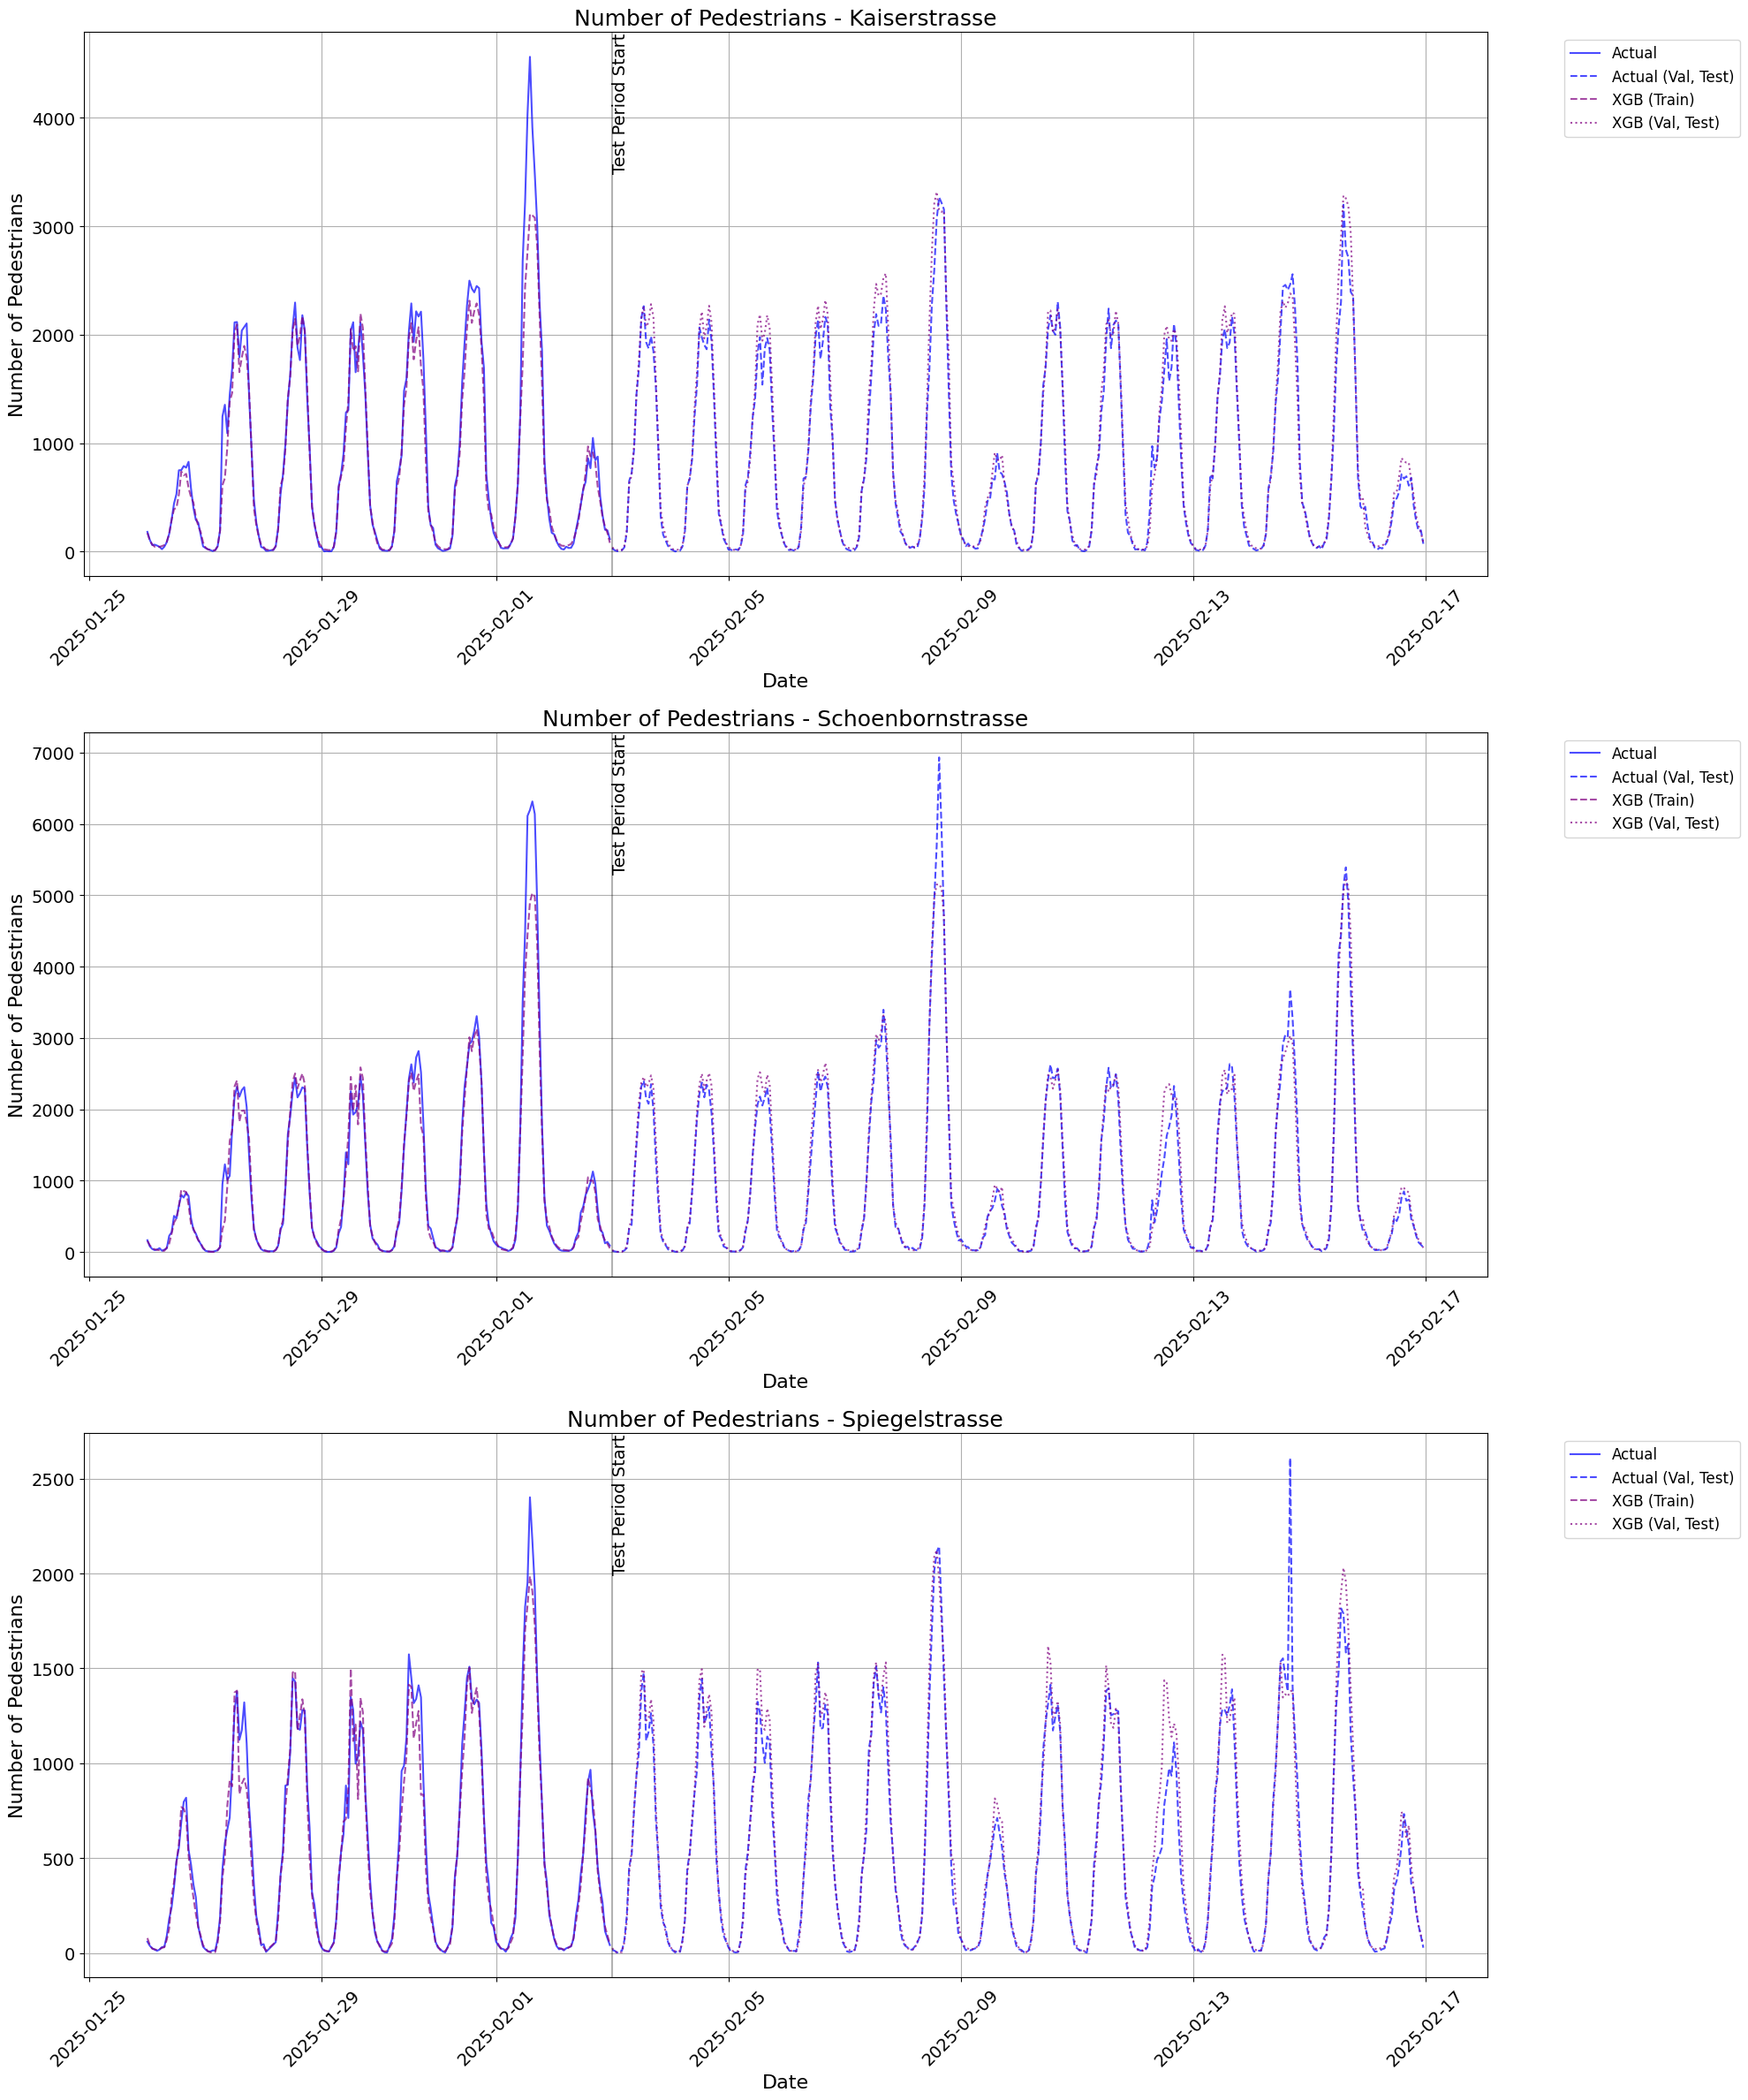


Generating metrics...

Results for n_pedestrians

Overall Metrics:
Model      MSE   RMSE   MAE   MAPE     R2
  XGB 41459.07 203.62 91.16 23.69% 0.9568

Street-wise Metrics:

kaiserstrasse:
Model      MSE   RMSE    MAE   MAPE     R2
  XGB 48333.64 219.85 102.71 33.09% 0.9454

schoenbornstrasse:
Model      MSE   RMSE    MAE   MAPE     R2
  XGB 65791.68 256.50 113.14 21.67% 0.9590

spiegelstrasse:
Model     MSE  RMSE   MAE   MAPE     R2
  XGB 9449.96 97.21 56.80 16.17% 0.9674

Best model for n_pedestrians: XGB (MSE: 41459.08)

Top 10 Important Features for XGB - n_pedestrians:
          Feature  Importance
is_shopping_hours    0.719268
 is_tourist_hours    0.184040
 is_working_hours    0.023358
       is_weekend    0.019290
         is_night    0.015831
   street_encoded    0.005349
is_public_holiday    0.004753
     hour_of_week    0.003258
  day_of_week_sin    0.002447
             hour    0.002266


Processing n_pedestrians_towards...
Training XGB...
Training Complete

Generating comp

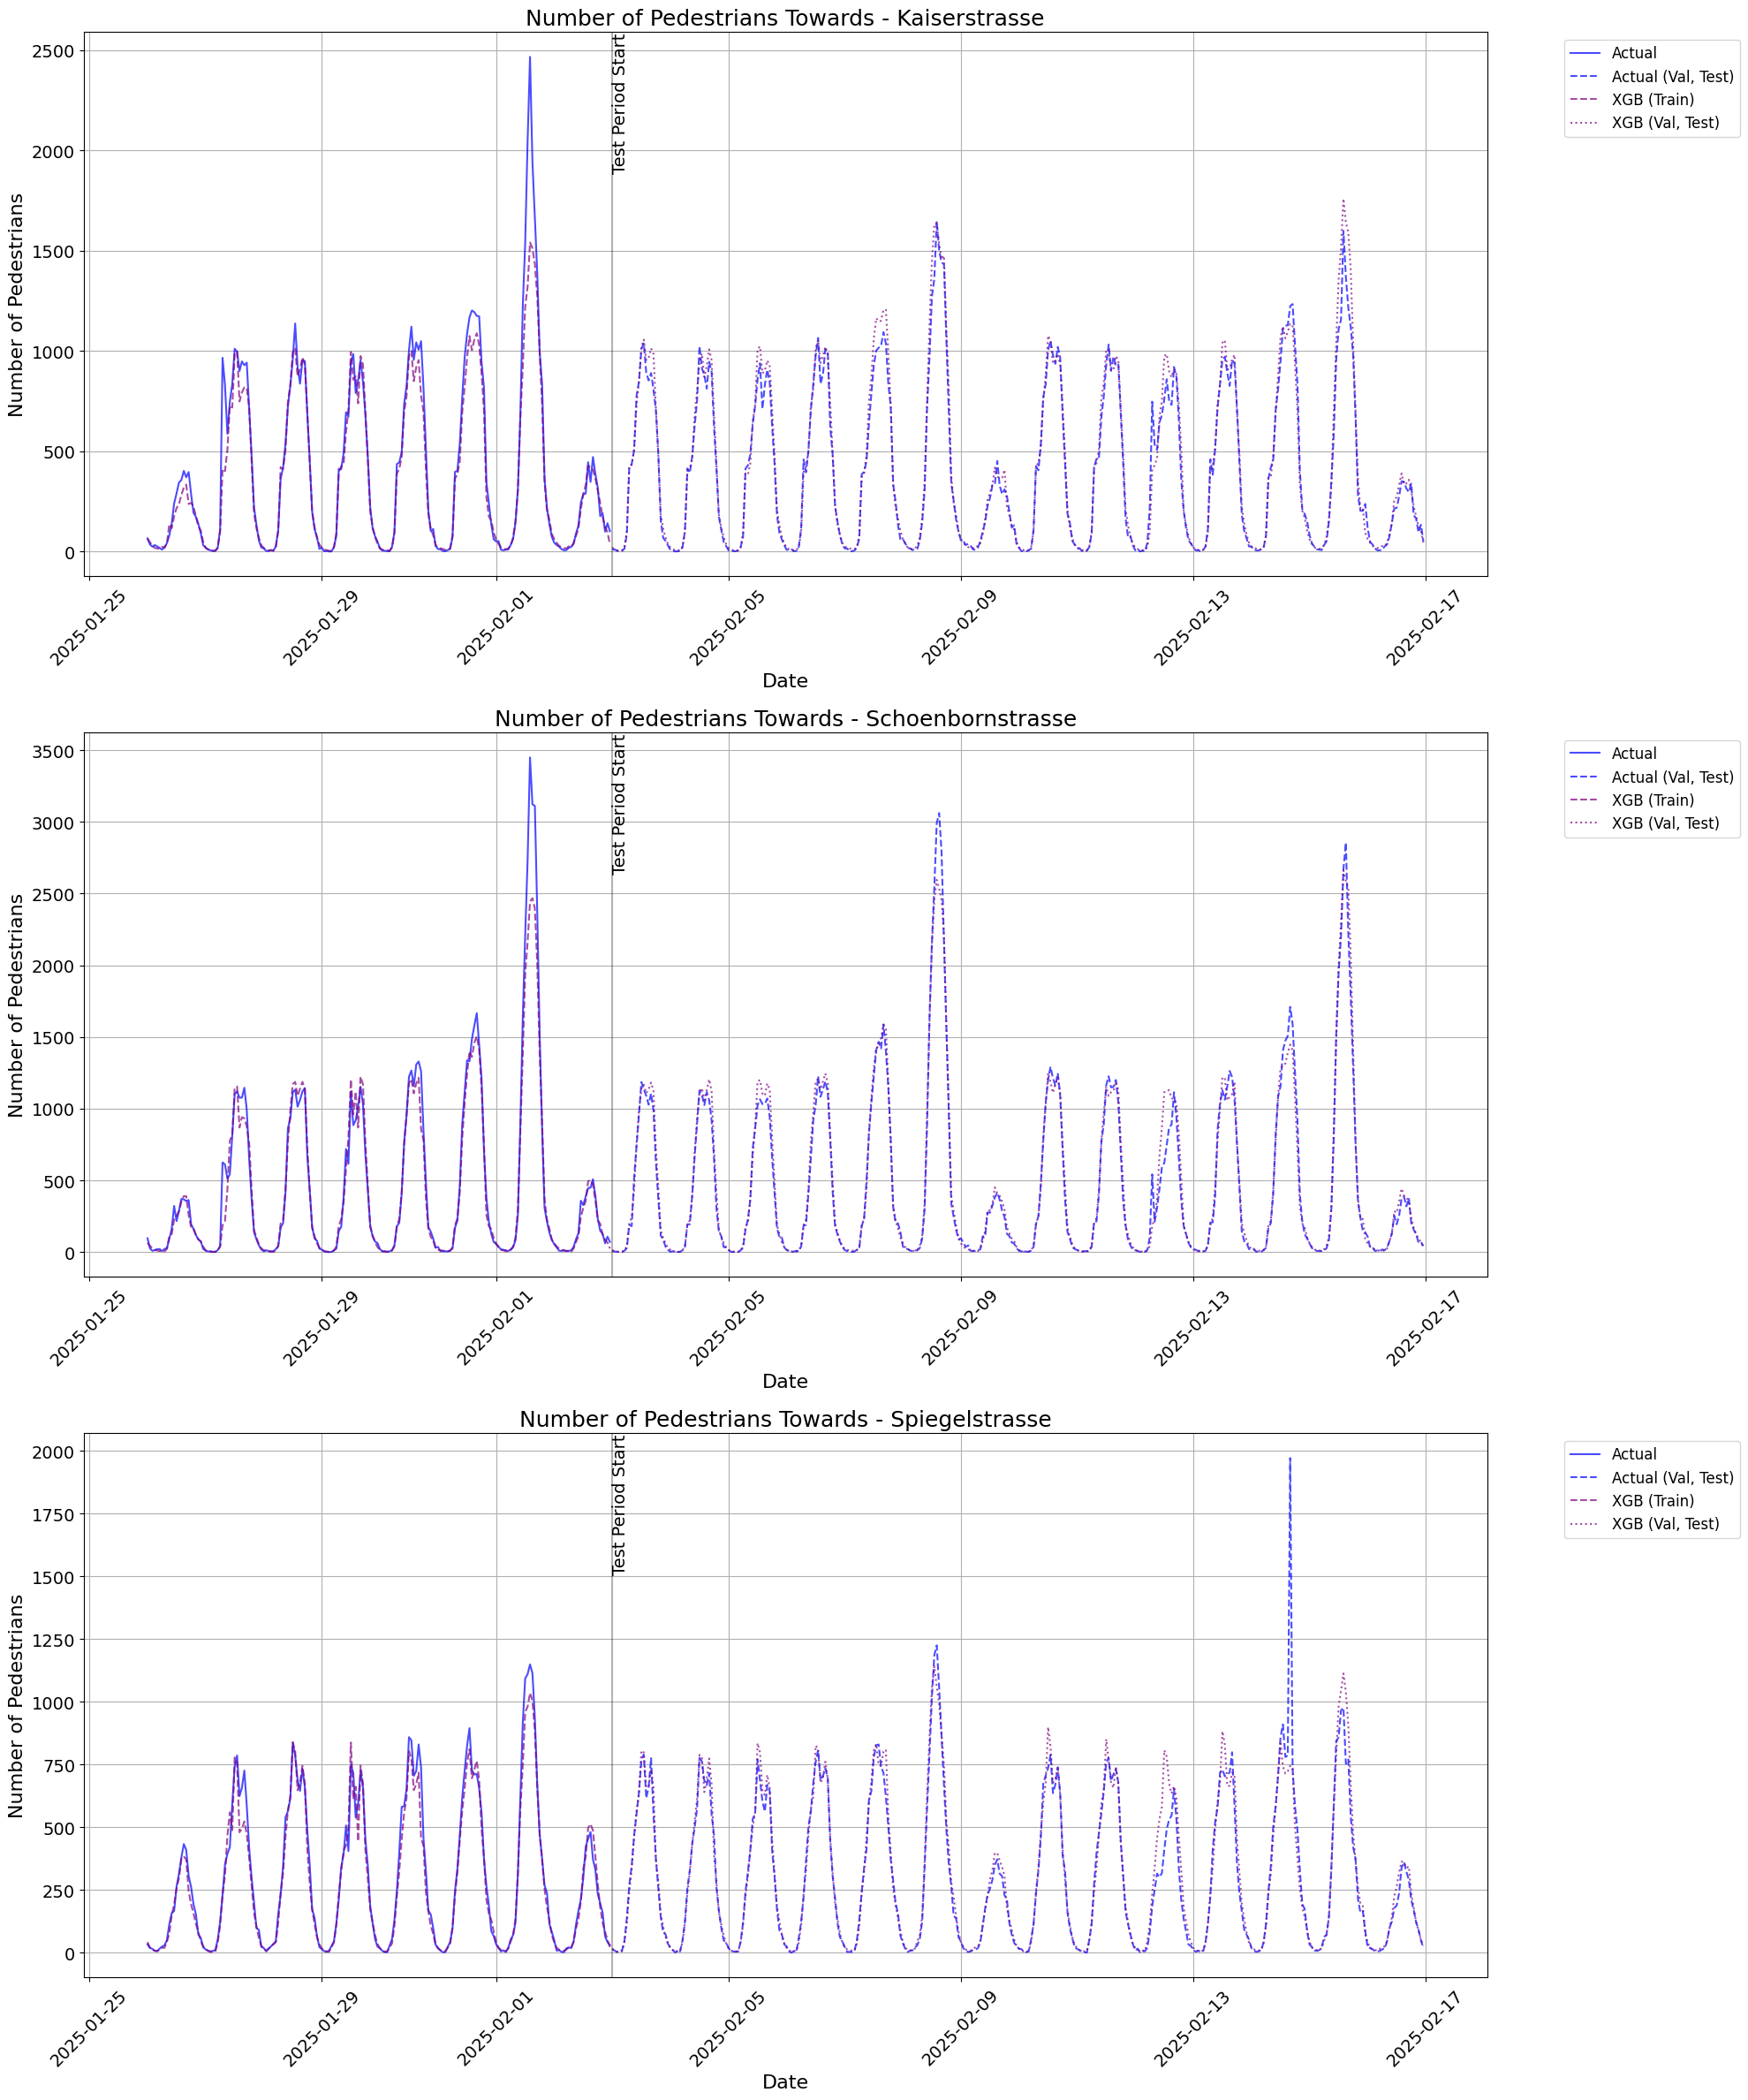


Generating metrics...

Results for n_pedestrians_towards

Overall Metrics:
Model      MSE   RMSE   MAE MAPE     R2
  XGB 12743.86 112.89 51.14 inf% 0.9458

Street-wise Metrics:

kaiserstrasse:
Model      MSE   RMSE   MAE MAPE     R2
  XGB 15502.64 124.51 56.45 inf% 0.9268

schoenbornstrasse:
Model      MSE   RMSE   MAE MAPE     R2
  XGB 19431.50 139.40 62.06 inf% 0.9502

spiegelstrasse:
Model     MSE  RMSE   MAE   MAPE     R2
  XGB 3058.34 55.30 34.49 22.75% 0.9649

Best model for n_pedestrians_towards: XGB (MSE: 12743.86)

Top 10 Important Features for XGB - n_pedestrians_towards:
          Feature  Importance
 is_tourist_hours    0.512666
is_shopping_hours    0.350709
         is_night    0.050591
 is_working_hours    0.025476
       is_weekend    0.018992
is_public_holiday    0.005191
   street_encoded    0.004874
     hour_of_week    0.003409
  day_of_week_sin    0.003005
         hour_sin    0.002623


Processing n_pedestrians_away...
Training XGB...
Training Complete

Generating

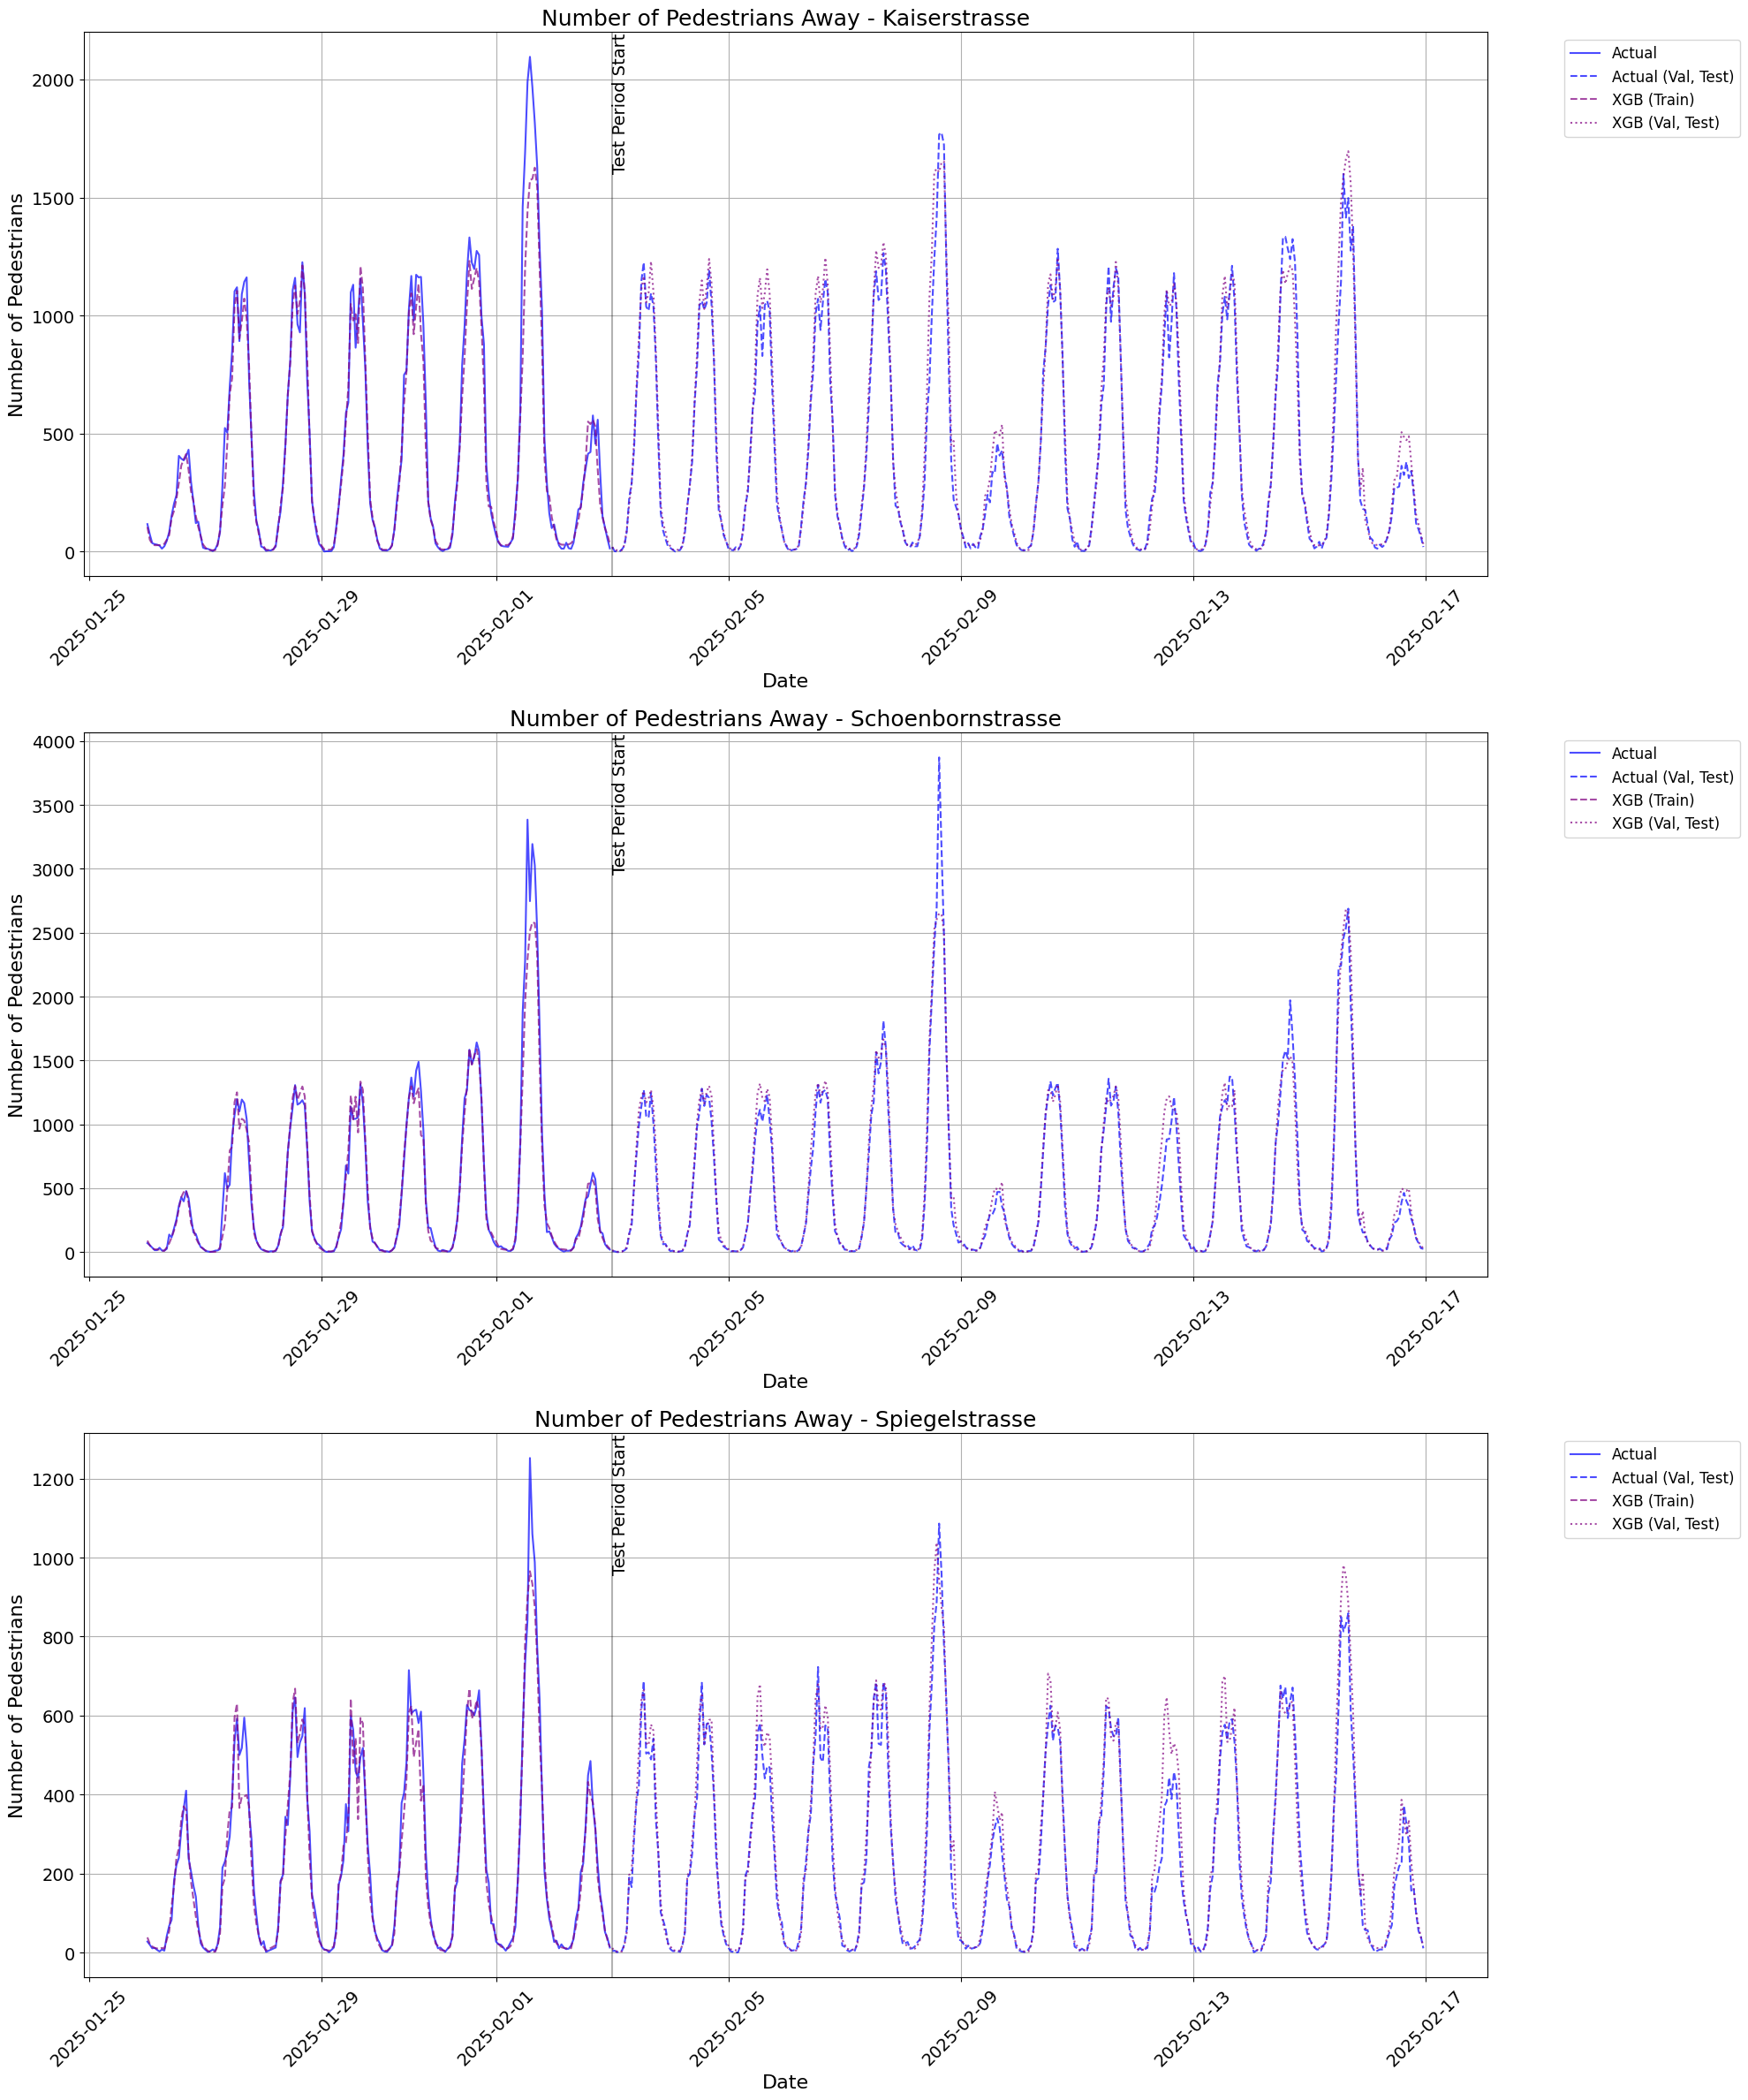


Generating metrics...

Results for n_pedestrians_away

Overall Metrics:
Model      MSE   RMSE   MAE   MAPE     R2
  XGB 10277.29 101.38 46.20 28.01% 0.9589

Street-wise Metrics:

kaiserstrasse:
Model      MSE   RMSE   MAE   MAPE     R2
  XGB 11454.08 107.02 53.12 31.39% 0.9515

schoenbornstrasse:
Model      MSE   RMSE   MAE   MAPE     R2
  XGB 16657.29 129.06 55.48 28.58% 0.9600

spiegelstrasse:
Model     MSE  RMSE   MAE   MAPE     R2
  XGB 2523.67 50.24 29.60 23.98% 0.9589

Best model for n_pedestrians_away: XGB (MSE: 10277.29)

Top 10 Important Features for XGB - n_pedestrians_away:
          Feature  Importance
is_shopping_hours    0.731661
 is_tourist_hours    0.165808
 is_working_hours    0.025292
       is_weekend    0.022373
         is_night    0.009178
   street_encoded    0.007095
is_public_holiday    0.005500
     hour_of_week    0.003688
         hour_sin    0.003070
             hour    0.002891


Submission file generated: /Users/kaigu/Documents/Universität/Doktorand/Pr

In [67]:
# USER SPECIFIED PARAMETERS
# Set tune_model_bool to True to enable hyperparameter tuning. Else the pre-specified parameters from above will be used.
# IMPORTANT NOTE: If you want to conduct hyperparameter tuning with parallelization (n_jobs > 1), make sure not (!) to use GPU training!!
# Otherwise, the tuning will not work as expected.

modelsToUse = ['xgb']  
tune_model_bool = False # If false, n_splits, n_iter, n_points_bayesSearch, n_jobs, and verbose are ignored
n_splits = 10
n_iter = 100
n_points_bayesSearch = 40
n_jobs = 10
verbose = 1
retrain_on_val = True # If true, the model will be retrained on the combined training and validation data for test predictions
deasonalize = False # If true, the target variable will be deseasonalized before training
output_path = f'{workingFolder}kaggle_v2/data_foot_traffic/submission.csv'

#---

models_selected = {model_name: model for model_name, model in models.items() if model_name in modelsToUse}
targets = ['n_pedestrians', 'n_pedestrians_towards', 'n_pedestrians_away']

best_models = {}
best_models_saved = {}
target_models = {}
all_val_predictions = {}
all_test_predictions = {}
all_submission_predictions = {}

for target in targets:
    print(f"\nProcessing {target}...")

    if deasonalize:

        # Deseasonalize the target variable
        seasonal_factors = X_train.groupby(['streetname', 'weekday', 'hour'])[[target]].mean().reset_index().rename({target: 'seasonal_factors'}, axis = 1)
        X_train = X_train.merge(seasonal_factors, on=['streetname', 'weekday', 'hour'], how='left')
        X_train[target] = X_train[target] - X_train['seasonal_factors']
        X_val = X_val.merge(seasonal_factors, on=['streetname', 'weekday', 'hour'], how='left')
        X_val[target] = X_val[target] - X_val['seasonal_factors']
        test_df = test_df.merge(seasonal_factors, on=['streetname', 'weekday', 'hour'], how='left')
        test_df_submission = test_df_submission.merge(seasonal_factors, on=['streetname', 'weekday', 'hour'], how='left')

    val_predictions = {}
    test_predictions = {}
    models_tuned = {}

    for model_name, model in models_selected.items():
        print(f"Training {model_name.upper()}...")

        if tune_model_bool:
            print(f"Starting hyperparameter-tuning for {model_name.upper()}...")
            
            # Tune hyperparameters
            cv_splits = get_cv_splits(X_train, n_splits=n_splits, len_split=168)

            cv_results = tune_model_random(model, param_dists[model_name], X_train[feature_cols], X_train[target], cv_splits, n_iter=n_iter, n_jobs=n_jobs, verbose=verbose)
            # cv_results = tune_model_bayes(model, search_spaces[model_name], X_train[feature_cols], X_train[target], cv_splits, n_iter=n_iter, n_points=n_points_bayesSearch, n_jobs=n_jobs, verbose=verbose)

            model = cv_results.best_estimator_            

            # print(f"Results Tuning {model_name}:{cv_results.cv_results_}")
            print("Best hyperparameters:")
            for param, value in cv_results.best_params_.items():
                print(f"  {param:<20}: {value}")

        else:      
            model.fit(X_train[feature_cols], X_train[target])
        
        val_preds = model.predict(X_val[feature_cols])

        if deasonalize:
            val_preds = val_preds + X_val['seasonal_factors']

        val_preds = np.clip(val_preds, a_min=0, a_max=None)
        val_predictions[model_name] = pd.DataFrame({target: val_preds}, index=X_val.index)

        if retrain_on_val:
            # Combine the training and validation data and retrain the model for the test predictions
            combined_df = pd.concat([X_train, X_val], ignore_index=True)
            model.fit(combined_df[feature_cols], combined_df[target]) 

        models_tuned[model_name] = model

        test_preds = model.predict(test_df[feature_cols])

        if deasonalize:
            test_preds = test_preds + test_df['seasonal_factors']

        test_preds = np.clip(test_preds, a_min=0, a_max=None)
        test_predictions[model_name] = pd.DataFrame({target: test_preds}, index=test_df.index)

        print("Training Complete")

    if deasonalize:
        X_train[target] = X_train[target] + X_train['seasonal_factors']
        X_val[target] = X_val[target] + X_val['seasonal_factors']
    
    all_val_predictions[target] = val_predictions
    all_test_predictions[target] = test_predictions
    
    print(f"\nGenerating comparison plot for {target}...")
    plot_model_comparison(X_val, val_predictions, test_df, test_predictions, val_test_actuals, target)
    
    print("\nGenerating metrics...")
    display_target_metrics(X_val, val_predictions, target)
    
    best_model, best_mse = get_best_model(models_tuned, X_val[target], val_predictions)
    best_models[target] = best_model
    print(f"\nBest model for {target}: {best_model.upper()} (MSE: {best_mse:.2f})")
    
    if best_model in ['rf', 'lgb', 'xgb']:
        display_feature_importance(models_tuned[best_model], feature_cols, best_model, target)

    # Generate the predictions for the submission file using the best_model for the target
    submission_preds = models_tuned[best_model].predict(test_df_submission[feature_cols])

    if deasonalize:
        submission_preds = submission_preds + test_df_submission['seasonal_factors']

    submission_preds = np.clip(submission_preds, a_min=0, a_max=None)
    all_submission_predictions[target] = pd.DataFrame({target: submission_preds}, index=test_df_submission.index)

    target_models[target] = models_tuned
    best_models_saved[target] = models_tuned[best_model]

    if deasonalize:
        X_train.drop(columns=['seasonal_factors'], inplace=True)
        X_val.drop(columns=['seasonal_factors'], inplace=True)
        test_df.drop(columns=['seasonal_factors'], inplace=True)
        test_df_submission.drop(columns=['seasonal_factors'], inplace=True)

with open('best_models.pkl', 'wb') as f:
    pickle.dump(best_models_saved, f)

submission_df = pd.DataFrame({'id': test_df_submission['id']})

for target in targets:
    best_model = best_models[target]
    submission_df[target] = all_submission_predictions[target][target].round(1)

submission_df.to_csv(output_path, index=False)
print(f"\nSubmission file generated: {output_path}")
print("Sample predictions:")
print(submission_df.head())

In [49]:
# Nicely format submission_df for new kaggle competition
test_df_forFormatting = pd.read_csv(f'{workingFolder}kaggle_v2/data_foot_traffic/test.csv')

submission_df_formatted = test_df_forFormatting.merge(submission_df, on='id', how='left')

submission_df_formatted = submission_df_formatted[['id', 'streetname', 'city', 
                                                   'date', 'hour', 'weekday', 'temperature', 'weather_condition', 'incidents', 'collection_type',
                                                   'n_pedestrians', 'n_pedestrians_towards', 'n_pedestrians_away']]

submission_df_formatted.to_csv(f'{workingFolder}kaggle_v2/data_foot_traffic/pedestrians_val_test_forecasts.csv', index=False)

# Performance Score

In [50]:
sub = pd.read_csv(f'{workingFolder}kaggle_v2/data_foot_traffic/submission.csv')
solution = pd.read_csv(f'{workingFolder}kaggle_v2/data_foot_traffic/solution.csv')
test_data = pd.read_csv(f'{workingFolder}kaggle_v2/data_foot_traffic/test.csv')

# Merge the column hour to sub and solution from test_data via the id column
sub = sub.merge(test_data[['id', 'hour']], on='id', how='left')
solution = solution.merge(test_data[['id', 'hour']], on='id', how='left')

targets = ['n_pedestrians', 'n_pedestrians_towards', 'n_pedestrians_away']

solutionVal = solution[solution.Usage == 'Public']
solutionTest = solution[solution.Usage == 'Private']

# Filter sub to only contain the rows that are in solution
subVal = sub[sub.id.isin(solutionVal.id)]
subTest = sub[sub.id.isin(solutionTest.id)]

subVal = subVal.set_index('id').sort_index()
subTest = subTest.set_index('id').sort_index()

solutionVal = solutionVal.set_index('id').sort_index()
solutionTest = solutionTest.set_index('id').sort_index()

In [51]:
mseVal = np.mean((solutionVal[targets] - subVal[targets])**2)
mseTest = np.mean((solutionTest[targets] - subTest[targets])**2)

print(f"Val-Score: {mseVal}")
print(f"Test-Score: {mseTest}")

Val-Score: 52525.18091931218
Test-Score: 30520.9539484127


In [52]:
# Filter subVal, subTest, solutionVal and solutionTest to only contain data between hour 8 and 22 and compute the MAPE for both
subVal = subVal[(subVal['hour'] >= 8) & (subVal['hour'] <= 22)]
subTest = subTest[(subTest['hour'] >= 8) & (subTest['hour'] <= 22)]
solutionVal = solutionVal[(solutionVal['hour'] >= 8) & (solutionVal['hour'] <= 22)]
solutionTest = solutionTest[(solutionTest['hour'] >= 8) & (solutionTest['hour'] <= 22)]

mapeVal = np.mean(np.abs((solutionVal[targets] - subVal[targets]) / solutionVal[targets])) * 100
mapeTest = np.mean(np.abs((solutionTest[targets] - subTest[targets]) / solutionTest[targets])) * 100

print(f"MAPE Val-Score: {mapeVal}")
print(f"MAPE Test-Score: {mapeTest}")

MAPE Val-Score: 14.759309125529349
MAPE Test-Score: 12.140381486919319


# SHAP

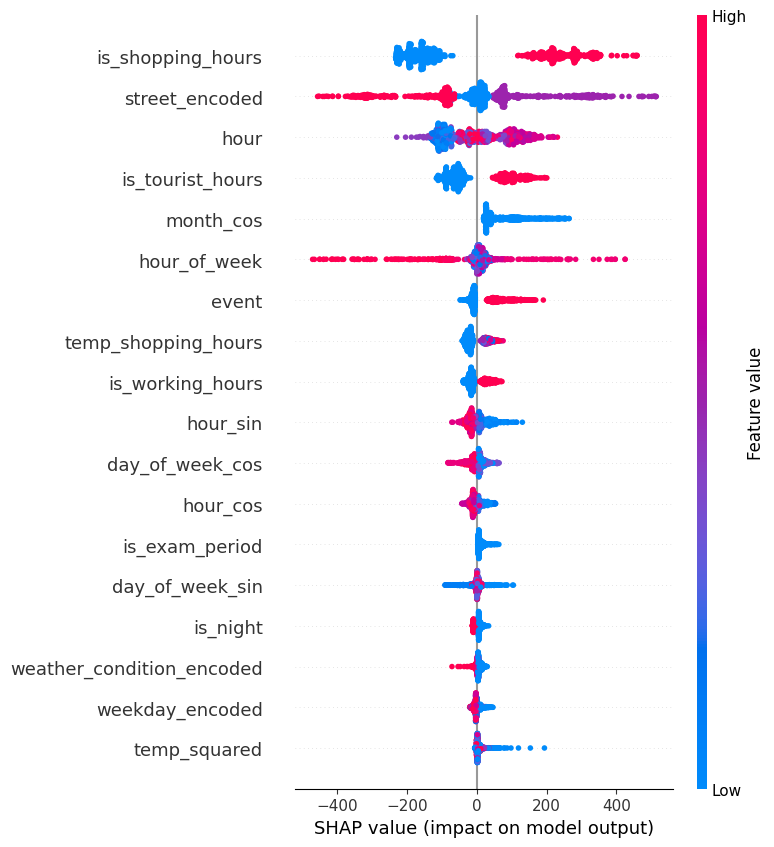

In [53]:
import shap

# Create a SHAP explainer
explainer = shap.Explainer(best_models_saved['n_pedestrians'])

# Compute SHAP values
shap_values = explainer(test_df[feature_cols])  # 👈 Use X_test or a sample of it

# Plot summary
shap.summary_plot(shap_values, test_df[feature_cols], max_display = 18)

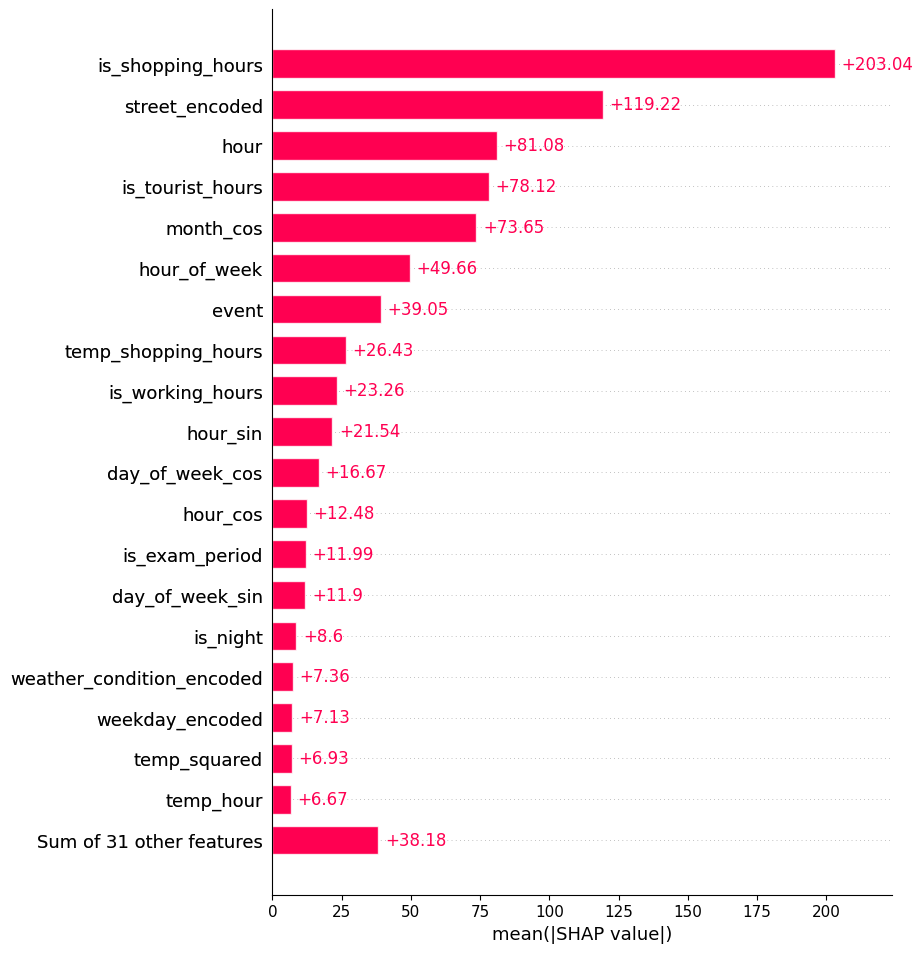

In [54]:
# Plot the feature importance using SHAP values
shap.plots.bar(shap_values, max_display=20)